В этом ноутбуке берется переписанный код статьи и проверяется корректность его запуска, а именно, что итоговые метрики будут похожи на предоставленные в статье.

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from PIL import Image 
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

from tqdm.notebook import tqdm
from IPython.display import clear_output

from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

In [3]:
model_name = 'tabddpm'
dataname = 'beijing'
dataname_initial = dataname
model_name_postfix=''

In [4]:
with open('./config.json', 'w', encoding='utf-8') as f:
    json.dump({
        'path': 'tabddpm.json',
        'model_name':'tabddpm'
    }, f, ensure_ascii=False, indent=4)

In [5]:
CONFIG.add_arg('num_clusters', 25)
CONFIG.add_arg('save_cat', 1)

In [6]:
download_dataset(dataname)
process_data(dataname)

Start processing dataset beijing from UCI.
Aready downloaded.
{'cat_col_idx': [0, 1, 2, 3, 8],
 'column_names': None,
 'data_path': 'data/beijing/beijing.csv',
 'file_type': 'csv',
 'header': 'infer',
 'name': 'beijing',
 'num_col_idx': [5, 6, 7, 9, 10, 11],
 'raw_data_path': 'data/beijing/PRSA_data_2010.1.1-2014.12.31.csv',
 'target_col_idx': [4],
 'task_type': 'regression',
 'test_path': None}
n_clusters: 25
beijing (37581, 12) (4176, 12) (41757, 12)
Numerical (37581, 6)
Categorical (37581, 5)
Processing and Saving beijing Successfully!
beijing
Total 41757
Train 37581
Test 4176
Num 7
Cat 5


### Проверка разделения

In [7]:
new_conf = {
               'dataname': dataname,
                 'method': 'tabddpm_v3_WITH_TRAIN_n_REAL',
                 'device': 'cuda',
                 'mode': 'train',
                 'train': 1,
                 'sample_save_path': f'synthetic/{dataname}/test.csv',
                 'sigma_scheduller_name': 'constant',
                 'sigma_value': 0.001,
                 'num_noise': 66,
                 'real_path': f'synthetic/{dataname}/real.csv',
                 'test_path': f'synthetic/{dataname}/test.csv',
                 'info_path': f'data/{dataname}/info.json',
            }
for key in new_conf.keys():
    CONFIG.add_arg(key, new_conf[key])
calculate_similarity()
clear_output()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 110.25it/s]|
Column Shapes Score: 98.57%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 117.78it/s]|
Column Pair Trends Score: 95.21%

Overall Score (Average): 96.89%

Error rate (%) of column-wise density estimation TABDDPM_V3_WITH_TRAIN_N_REAL: 1.434 ± 1.032
Error rate (%) of pair-wise column correlation score TABDDPM_V3_WITH_TRAIN_N_REAL: 4.789 ± 4.611


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


TypeError: can't multiply sequence by non-int of type 'float'

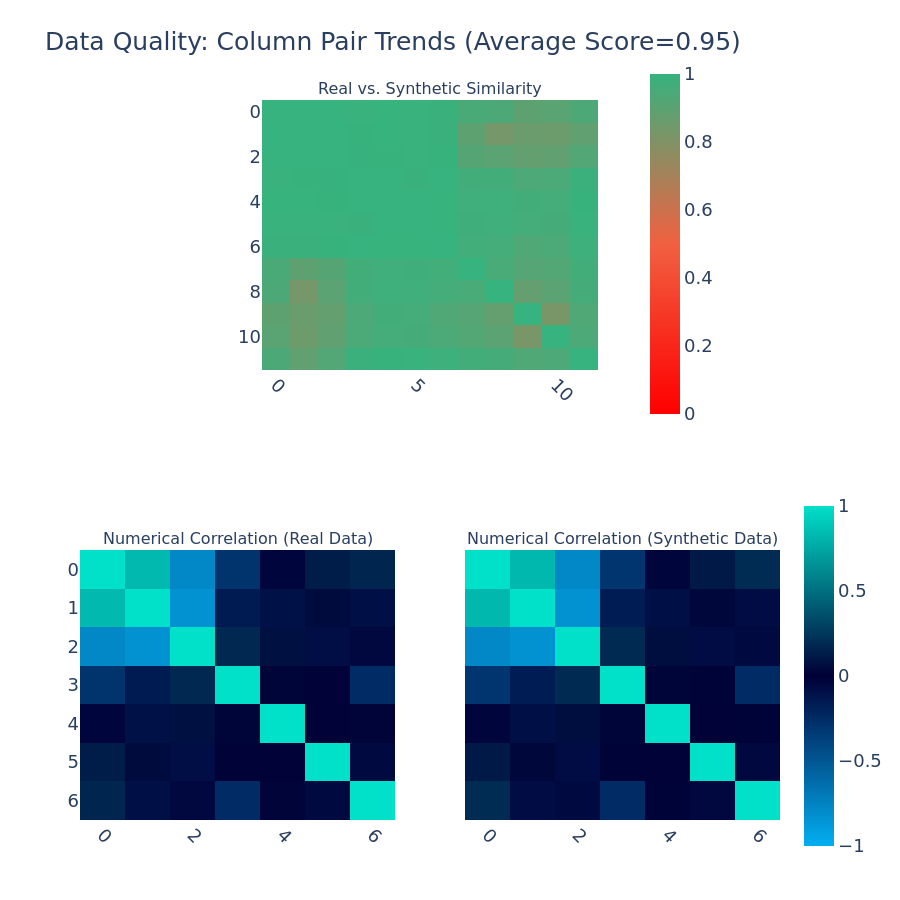

In [8]:
im = Image.open(f"./eval/similarity/{dataname}/tabddpm_v3_WITH_TRAIN_n_REAL/pair-wise-column-correlation.png")
im.show()

### Подготовка

In [9]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [10]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('sample_save_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('real_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")
CONFIG.add_arg('info_path',
               f"data/{CONFIG.get_arg('dataname')}/info.json")

Device: cuda


In [11]:
CONFIG.get_all_args()

{'dataname': 'beijing',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/beijing/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 66,
 'real_path': 'synthetic/beijing/real.csv',
 'test_path': 'synthetic/beijing/test.csv',
 'info_path': 'data/beijing/info.json',
 'save_path': './synthetic/x/initial_tabddpm_test.csv',
 'num_clusters': 25,
 'save_cat': 1}

### Train

In [12]:
CONFIG.add_arg('mode', 'train')

In [13]:
model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}"

In [14]:
model_save_path

'./models/tabddpm/ckpt/beijing/tabddpm'

In [16]:
tabddpm = TabDDPM(CONFIG, model_save_path=model_save_path)

In [18]:
tabddpm.train()

In [ ]:
for file in tqdm(os.listdir(model_save_path)):
    if ('0000' in file) or ('model_ema.pt' in file):
        os.remove(os.path.join(model_save_path, file))

In [ ]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(10)

In [ ]:
loss = pd.read_csv(f'{model_save_path}/loss.csv')
max_v, min_v = -np.inf, np.inf
window = 250

start_step = 0
for i, l in enumerate(loss.columns[1:]):
    plt.plot(loss['step'][start_step:], loss[l][start_step:], alpha=0.25, color=cmap(i))
    smoothed = np.convolve(loss[l][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=l, color=cmap(i))

    max_v = np.max([np.quantile(loss[l][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss[l][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1]) 
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")
plt.savefig(f'{model_save_path}/loss_image.png')
plt.show()

In [51]:
tabddpm.sample(sample_save_path=CONFIG.get_arg('sample_save_path'))

No NaNs in numerical features, skipping
mlp
torch.Size([10000, 2])
Sample timestep    0
torch.Size([10000, 2])
Sample timestep    0
Shape torch.Size([17117, 11])
(17117, 1)
Sampling time: 99.40996408462524


### Расчет метрик

In [52]:
CONFIG.get_arg('sample_save_path')

'synthetic/magic/tabddpm.csv'

In [53]:
CONFIG.get_all_args()

{'dataname': 'magic',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/magic/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 66,
 'real_path': 'synthetic/magic/real.csv',
 'test_path': 'synthetic/magic/test.csv',
 'info_path': 'data/magic/info.json',
 'save_path': './synthetic/shoppers_ON_QnSC_100k/initial_tabddpm_ON_QnSC_100k_mult_6.csv',
 'num_clusters': 25,
 'save_cat': 1}

In [54]:
overall_metrics = {}
overall_metrics[model_name] = {}

#### Метрики из starter_kit

In [55]:
pd.read_csv('synthetic/magic/tabddpm.csv')['class'].unique()

array(['h', 'g'], dtype=object)

In [56]:
overall_metrics[model_name]['base_metrics'] = calculate_base_metrics(make_binary=True, value='h')

TABDDPM: MAGIC Dataset
Original Logistic: 0.712
Synthetic Logistic: 0.716
Original Tree: 0.752
Synthetic Tree: 0.725 

TABDDPM Accuracy Loss: MAGIC
Logistic: -0.604%
Tree: 3.540% 



#### Метрики из статьи TabSyn

In [57]:
overall_metrics[model_name]['similarity'] = calculate_similarity()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 119.69it/s]|
Column Shapes Score: 98.96%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 102.93it/s]|
Column Pair Trends Score: 99.25%

Overall Score (Average): 99.11%

Error rate (%) of column-wise density estimation TABDDPM: 1.040 ± 0.403
Error rate (%) of pair-wise column correlation score TABDDPM: 0.746 ± 0.762


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


DONE!


#### MLE

In [58]:
overall_metrics[model_name]['mle'] = calculate_mle()

100%|██████████| 36/36 [00:06<00:00,  5.37it/s]


Saving scores to  eval/mle/magic/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.927 ± 0.004


#### Detection: classifier two sample tests (C2ST)

In [59]:
overall_metrics[model_name]['detection'] = calculate_detection()

magic, tabddpm: 0.995231036281964


#### DCR

In [60]:
overall_metrics[model_name]['DCR'] = calculate_DCR()

DCR Score, a value closer to 0.5 is better
magic-tabddpm, DCR Score = 0.9055909329905941


#### Alpha precision & Beta recall

In [61]:
dataname = CONFIG.get_arg('dataname')
model = CONFIG.get_arg('method')
f'synthetic/{dataname}/{model}.csv'

'synthetic/magic/tabddpm.csv'

In [62]:
CONFIG.get_all_args()

{'dataname': 'magic',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/magic/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 66,
 'real_path': 'synthetic/magic/real.csv',
 'test_path': 'synthetic/magic/test.csv',
 'info_path': 'data/magic/info.json',
 'save_path': './synthetic/shoppers_ON_QnSC_100k/initial_tabddpm_ON_QnSC_100k_mult_6.csv',
 'num_clusters': 25,
 'save_cat': 1}

In [80]:
overall_metrics[model_name]['quality'] = calculate_alpha_beta()

=========== All Features ===========
Data shape:  (17117, 12)
alpha precision: 0.981142, beta recall: 0.479632


### Табличка

In [81]:
final_metrics_table = []
for m in overall_metrics.keys():
    # Сбор таблички результатов
    tmp = pd.DataFrame([{'Model':'TabDDPM', 'Type':m, 'Data':dataname}])
    tmp.columns = pd.MultiIndex.from_tuples([('', i) for i in tmp.columns])
    result = [tmp]
    
    for metric_group in overall_metrics[m].keys():
        tmp = pd.DataFrame([overall_metrics[m][metric_group]])
        tmp.columns = pd.MultiIndex.from_tuples([(metric_group, i) for i in tmp.columns])
        result.append(tmp)
    result = pd.concat(result, axis = 1)
    final_metrics_table.append(result)
    
final_metrics_table = pd.concat(final_metrics_table)

In [82]:
pd.set_option('display.max_columns', None)
final_metrics_table.round(4)

base_metrics                                   \
     Model     Type   Data Original Logistic Synthetic Logistic Original Tree   
0  TabDDPM  tabddpm  magic             0.712             0.7163        0.7521   

                                                                  \
  Synthetic Tree Accuracy Loss Logistic, % Accuracy Loss Tree, %   
0         0.7255                   -0.6036                3.5397   

              similarity                              \
  Column Shapes Score, % Column Pair Trends Score, %   
0                98.9596                     99.2541   

                              \
  Overall Score (Average), %   
0                    99.1069   

                                                       \
  Error rate (%) of column-wise density estimation, %   
0                                              1.0404   

                                                           \
  Error rate (%) of column-wise density estimation std, %   
0                                                  0.4033   

                                                           \
  Error rate (%) of pair-wise column correlation score, %   
0                                                  0.7459   

                                                               \
  Error rate (%) of pair-wise column correlation score std, %   
0                                                      0.7617   

                                         mle  \
  ROC - AUC обучения на синтетических данных   
0                                     0.9274   

                                                  detection     DCR  \
  ROC - AUC обучения на синтетических данных, std     Score   Score   
0                                          0.0035    0.9952  0.9056   

          quality              
  alpha precision beta recall  
0          0.9811      0.4796

In [83]:
import os
if not os.path.exists(f'./eval/total/{dataname}'):
    os.makedirs(f'./eval/total/{dataname}')
final_metrics_table.to_csv(f'./eval/total/{dataname}/{model_name}{model_name_postfix}_final_metrcs_table.csv', index=False)

In [84]:
f'./eval/total/{dataname}/{model_name}{model_name_postfix}_final_metrcs_table.csv'

'./eval/total/magic/tabddpm_final_metrcs_table.csv'